In [7]:
import requests as req
from bs4 import BeautifulSoup
import json
import pandas as pd
from standardize import *
from key import api_key
from key import g_api_key
import re
import os
import bokeh as bo
import numpy as np 
import matplotlib as mp
from helper import *
import geopandas as gp
from shapely.geometry import Point

In [4]:
rodent_list = ['rats','rat','mice','mouse',\
'racoon','racoons','possum','vermin','rodent','rodents','roach','roaches','cockroach','cockroaches','termite','termites']

url = "https://data.milwaukee.gov/api/3/action/datastore_search?resource_id"

#rats_endpoint = "resource_id=bf2b508a-5bfa-49da-8846-d87ffeee020a&q=rats"



In [5]:
def get_complaint_type_dfs(ln_list, url):

    historical = 'bf2b508a-5bfa-49da-8846-d87ffeee020a'
    current = 'abdfe983-e856-40cd-bee2-85e78454344a'

    df = pd.DataFrame()  #pull_data(url_sql, rats_endpoint, api_key)

    for rec_id in [historical, current]:
        for end in ln_list:
            endpoint = '='+rec_id+'&q='+end
            new_df = pull_data(url,endpoint,api_key)
            new_df['lookup_term'] = end
            df = df.append(new_df)
    
    return df

    #df.drop_duplicates(inplace=True)

In [21]:
df = get_complaint_type_dfs(rodent_list, url)

In [22]:
df.shape

(0, 1)

In [5]:
df.iloc[18].CASECLOSUREREASONDESCRIPTION

''

In [6]:
df.head()

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,lookup_term,rank
0,Record number 3179788 is a request for Sanitat...,2019-01-05 10:38:21,2019-01-02 18:37:11,1505 N FRANKLIN PL # 101,Approx Area Collection Requests,2132.0,possum,0.057309
1,Record number 3179687 is a request for Sanitat...,2019-01-05 10:30:58,2019-01-02 15:14:33,2150 N 36TH ST,Approx Area Collection Requests,2318.0,possum,0.057309
0,,2011-11-16 08:15:26,2011-10-26 20:27:57,3820 N HUMBOLDT BL,Rats Or Rat Harborage,1496343.0,rats,0.057309
1,Record number 3164787 is a request for Sanitat...,2018-11-27 10:31:13,2018-11-20 15:05:54,1115 E WRIGHT ST,Tree Trimming Web,16955.0,rats,0.057309
2,Record number 3162955 is a request for Sanitat...,2018-11-19 11:20:37,2018-11-15 13:11:44,5910 N 37TH ST,Call Back Sanitation Web,19222.0,rats,0.057309


In [7]:
cols = list(df.columns)
cols.remove('lookup_term')

In [8]:
df = df.groupby(cols).apply(lambda x: ','.join(x.lookup_term)).to_frame().reset_index().rename(columns={'0':'cats'})

In [9]:
df.rename(columns={0:'categories'},inplace=True)

In [10]:
df.head()

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,rank,categories
0,,2011-11-16 08:15:26,2011-10-26 20:27:57,3820 N HUMBOLDT BL,Rats Or Rat Harborage,1496343.0,0.057309,"rats,rat"
1,,2011-12-01 08:15:28,2011-11-24 19:03:40,2123 N 47TH ST,Rats Or Rat Harborage,1495292.0,0.057309,"rats,rat"
2,,2011-12-01 08:15:29,2011-11-24 19:08:25,4712 W LLOYD ST,Rats Or Rat Harborage,1495290.0,0.057309,"rats,rat"
3,,2012-02-20 09:59:58,2011-12-24 23:41:44,2904 W WISCONSIN AV # 101,Rats Or Rat Harborage,1493156.0,0.057309,"rats,rat"
4,,2012-02-21 08:16:54,2012-02-02 18:17:51,4712 W LLOYD ST,Rats Or Rat Harborage,1486784.0,0.057309,"rats,rat"


In [11]:
titles_df = df.groupby('TITLE').size().to_frame().reset_index().rename(columns={0:'cts','TITLE':'issue'}).sort_values('cts', ascending=False)
tt_5 = titles_df[:5]

In [12]:
categories_df = df.groupby('categories').size().to_frame().reset_index().rename(columns={0:'cts'}).sort_values('cts', ascending=False)

In [13]:
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from math import pi


output_notebook()
#output_file('vbar.html')

#data = {'issues': list(tt_5.issues), 'cts': np.ndarray(tt_5.cts)}

source = ColumnDataSource(data=dict(issue=tt_5.issue, cts=np.array(tt_5.cts)))

issue = source.data['issue'].tolist()

#print(dict(issues=list(tt_5.issue), cts=np.array(tt_5.cts)))

p = figure(x_range=tt_5.issue,plot_width=400, plot_height=400,toolbar_location=None)
p.vbar(x='issue', width=.9, bottom=0, source = source,
        top='cts', fill_color=factor_cmap('issue', palette=Spectral6, factors=tt_5.issue))
p.xaxis.major_label_orientation = pi/2.7
#p.vbar(x =titles_df.issue, width=0.5, top = titles_df.cts, bottom=0,color="firebrick")
show(p)


Loading BokehJS ...

In [14]:
df[df.TITLE=='Mice/Roach Infestation']

,CASECLOSUREREASONDESCRIPTION,CLOSEDDATETIME,CREATIONDATE,OBJECTDESC,TITLE,_id,rank,categories


In [15]:
tc_5 = categories_df[:5]

source = ColumnDataSource(data=dict(categories=tc_5.categories, cts=np.array(tc_5.cts)))

issue = source.data['categories'].tolist()

p = figure(x_range=tc_5.categories, plot_width=400, plot_height=400,toolbar_location=None)
p.vbar(x='categories', width=.9, bottom=0, source = source,
        top='cts', fill_color=factor_cmap('categories', palette=Spectral6, factors=tc_5.categories))
p.xaxis.major_label_orientation = pi/2.7
#p.vbar(x =titles_df.issue, width=0.5, top = titles_df.cts, bottom=0,color="firebrick")
show(p)

In [16]:
#c(" AV ", " DR ", " ST ", " RD ", " BL ", " PL ",
#                    " LA ", " CR ", " WA ", " CT ", " TR ", " PK ")
#http://maps2.milwaukee.gov/ArcGIS/rest/services/geocode/MAIthenDIME_geocode/GeocodeServer/findAddressCandidates?Street=3820+North+Humboldt+BL&SingleLine=&outFields=Loc_name&outSR=&f=json
import json
from bs4 import BeautifulSoup

def geo_locate(x):
    if not len(x):
        return [None,None,None]
    gl = "http://maps2.milwaukee.gov/ArcGIS/rest/services/geocode/MAIthenDIME_geocode/GeocodeServer/findAddressCandidates?Street="
    address = x.replace(' ','+')
    response = req.get(gl+address+'&SingleLine=&outFields=Loc_name&outSR=&f=json')
    if 'html' in str(response.content):
        soup = BeautifulSoup(response.content,'html.parser')
        #print(soup)
        #for i in soup.find('ul'):
        east, north = re.findall(r'[0-9/.]+',soup.find('ul').text)
        zipcode  = re.findall(r'[0-9]{5}',soup.find('ul').text)[0]
        if zipcode !=None:
            return [east,north,zipcode]
        else:
            return [east,north,None]
    else:
        #print(address)
        #print(response.content)
        res = response.json()
        if not len(res['candidates']):
            return [None,None,None]
        #print(res)
        result = res['candidates'][0]
        #print(result)
        geodata = dict()
        geodata['east'] = result['location']['x']
        geodata['north'] = result['location']['y']
        
        result1 = res['candidates'][1]
        
        geodata['address'] = result1['address']
        
        #print(geodata['address'])
        
        if (len(geodata['address'].split(',')) == 2):
        
            geodata['zip'] = geodata['address'].split(',')[1]
            
        else:
            
            geodata['zip'] = None
            
        #print(geodata['address'])
        
    return [geodata['east'], geodata['north'], geodata['zip']]

In [17]:
df['utm_zip'] = df.OBJECTDESC.apply(lambda x: geo_locate(x))

In [18]:
df.utm_zip.tail()

2561      [2545607.929078192, 392477.09585369047, None]
2562      [2562016.357664272, 389722.0751622523, 25620]
2563    [2547794.732782273, 392340.90181008715,  53208]
2564    [2536159.739935282, 366801.42942045926,  53219]
2565     [2540418.631161882, 391224.9931794932,  53208]
Name: utm_zip, dtype: object

In [19]:
df['easting'] = df.utm_zip.apply(lambda x: float(x[0]) if x[0] !=None else None)
df['northing'] = df.utm_zip.apply(lambda x: float(x[1]) if x[1] !=None else None)
df['point'] = df.utm_zip.apply(lambda x: Point([float(x[0]),float(x[1])]) if x[1] !=None else None)
df['zip'] = df.utm_zip.apply(lambda x: x[2] if x[2] !=None else None)

In [20]:
df.to_csv('rodents.csv')

In [18]:
df = pd.read_csv('rodents.csv')

In [19]:
df.shape

(2566, 14)

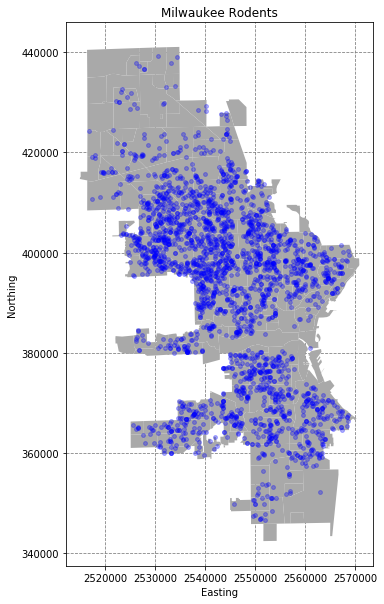

In [21]:
mil_link= 'neighborhood2.shp'
mil = gp.read_file(mil_link)
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

#colors
#https://matplotlib.org/gallery/color/colormap_reference.html

#cmap = ListedColormap(['winter'], name='winter')

fig,ax = plt.subplots(1, 1, figsize=(20,10))
mil.plot(color='darkgray', ax =ax)

event_locs = gp.GeoDataFrame(df[['point']],
                            crs=mil.crs).rename(columns={'point':'geometry'})

event_locs.plot(ax=ax, 
                                color = 'blue', 
                                marker = '.',
                                alpha = .3,
                                markersize = 60)

ax.set(xlabel = 'Easting',
      ylabel='Northing',
      title="Milwaukee Rodents")
ax.set_axisbelow(True)
ax.yaxis.grid(color ='gray',
             linestyle='dashed')
ax.xaxis.grid(color ='gray',
             linestyle='dashed')


In [22]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

mil.iloc[0].geometry.contains(df.iloc[0].point)

False

In [23]:
def count_points_poly(df, poly, r_type = None):
    count = 0
    
    if r_type:
        df  = df[df.categories.str.contains(r_type)]

    for index, row in df.iterrows():
        if pd.notnull(row['easting']):
        
            if poly.contains(row['point']):
                count+=1
    return count




In [36]:
mil['r_points'] = mil.geometry.apply(lambda x: count_points_poly(df, x))
mil['rat_points'] = mil.geometry.apply(lambda x: count_points_poly(df, x,'rat'))

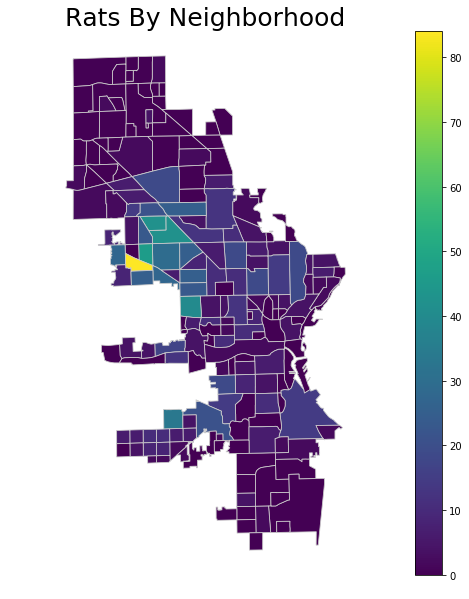

In [40]:
fig,ax = plt.subplots(1, 1, figsize=(20,10))

mil.plot(column='rat_points',cmap = 'viridis', ax =ax, linewidth=0.8, edgecolor='0.8')

event_locs = gp.GeoDataFrame(df[['point']],
                            crs=mil.crs).rename(columns={'point':'geometry'})

#event_locs.plot(ax=ax, 
#                                 color = 'blue', 
#                                 marker = '.',
#                                 alpha = .3,
#                                 markersize = 60)
ax.axis('off')

ax.set_title('Rats By Neighborhood', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.set(xlabel = 'Easting',
#       ylabel='Northing',
#       title="Milwaukee Rodents")
# ax.set_axisbelow(True)
# ax.yaxis.grid(color ='gray',
#              linestyle='dashed')
# ax.xaxis.grid(color ='gray',
#              linestyle='dashed')

vmin = min(mil.r_points)
vmax = max(mil.r_points)
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


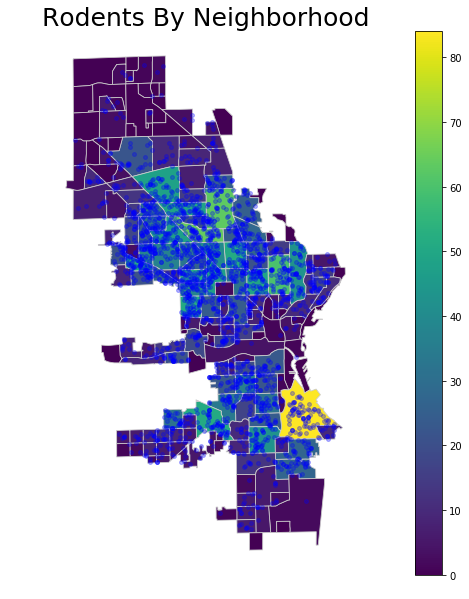

In [38]:
#mil['r_points'] = mil.geometry.apply(lambda x: count_points_poly(df, x))

fig,ax = plt.subplots(1, 1, figsize=(20,10))

mil.plot(column='r_points',cmap = 'viridis', ax =ax, linewidth=0.8, edgecolor='0.8')

event_locs = gp.GeoDataFrame(df[['point']],
                            crs=mil.crs).rename(columns={'point':'geometry'})

event_locs.plot(ax=ax, 
                                color = 'blue', 
                                marker = '.',
                                alpha = .3,
                                markersize = 60)
ax.axis('off')

ax.set_title('Rodents By Neighborhood', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.set(xlabel = 'Easting',
#       ylabel='Northing',
#       title="Milwaukee Rodents")
# ax.set_axisbelow(True)
# ax.yaxis.grid(color ='gray',
#              linestyle='dashed')
# ax.xaxis.grid(color ='gray',
#              linestyle='dashed')

vmin = min(mil.r_points)
vmax = max(mil.r_points)
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)


In [39]:
mil.head()

,AREA,PERIMETER,NBHDTEXT_,NBHDTEXT_I,NEIGHBORHD,SYMBOL,geometry,rat_points,r_points
0,1.426421e+07,16265.34290,80,80,NORTHRIDGE LAKES,2,"POLYGON ((2534922.098 435686.045, 2533594.7034...",1,2
1,1.834711e+07,21032.81061,33,33,NORTHRIDGE,3,"POLYGON ((2532293.169 441012.249, 2532294.9876...",0,1
2,6.719799e+06,10321.33251,34,34,RIDGEVIEW,1,"POLYGON ((2529454.939 440933.719, 2529450.372 ...",0,0
3,4.611659e+07,31484.83408,32,32,NORTH GRANVILLE,3,"POLYGON ((2516440.234 440484.256, 2522280.447 ...",0,0
4,9.945578e+06,12659.02962,79,79,NORTH MEADOWS,4,"POLYGON ((2526982.705 439439.741, 2526980.92 4...",0,2


In [ ]:
#Next Rodent Calls Per Capita?
#By Zip
#What would be meaningful?
#make interactive
#make in shiny or d3?

In [29]:
# import utm
# from pyproj import Proj

# #utm.to_latlon()
# #16T
# #+proj=utm +zone=19 +ellps=GRS80 +datum=NAD83 +units=m +no_defs
# p1 = Proj(proj='latlong',datum='WGS84', inverse=True)
# x1 = -87.9249; y1 = 43.0422
# #p2 = Proj(proj="utm",zone=16,datum='NAD27', inverse=True)
# #x2, y2 = transform(p1, p2, x1, y1)
# #print("%s  %s" % (str(x2)[:9],str(y2)[:9]))

# myProj = Proj(proj='utm', zone=16, strict='T', datum="NAD27")

# def to_utm(x):
#     #print(x)
#     if(x[1] !=None and x[0] != None):
#         #tup = myProj(float(x[1]),float(x[0])+2000000.0, inverse=True)
#         p2 = Proj(proj="utm",zone=16,datum='NAD27')
#         x2, y2 = transform(p2, p1, x[1], str(float(x[0])))
#         #tup = utm.to_latlon(float(x[1]),float(x[0])+2000000.0,16,'T')
#         return [y2,x2]
#     else:
#         return (None,None)

# df['lat_long'] = df.utm_zip.apply(lambda x: to_utm(x))
# #df['northing'] = df.utm_zip.apply(lambda x: float(x[1]) if x[1] !=None else None)

In [30]:
# df['long'] = df.lat_long.apply(lambda x: x[1])
# df['lat'] = df.lat_long.apply(lambda x: x[0])

In [31]:
# import folium
# from folium import plugins
# import matplotlib.pyplot as plt

In [32]:
# df_fol = df[pd.notnull(df.lat)]
# df_fol = df[pd.notnull(df.long)]

In [33]:
# df_fol.head(40)

In [34]:
# m = folium.Map([43.0422, -87.9249], zoom_start=12)

# #try pyproj, utm dontwork

# for index, row in df_fol.iterrows():
#     #print(row)
#     folium.CircleMarker([row['lat']+20, row['long']],
#                         radius=3,
#                         popup=row['OBJECTDESC'],
#                         fill_color="#3db7e4", # divvy color
#                        ).add_to(m)

# m.save("Map1.html")

In [35]:
# for index, row in df_fol.iterrows():
#     folium.CircleMarker([row['lat'], row['long']],
#                         radius=15,
#                         popup=row['OBJECTDESC'],
#                         fill_color="#3db7e4", # divvy color
#                        ).add_to(m)
#convert to (n, 2) nd-array format for heatmap
# rodentPlace = df_fol[['long', 'lat']].values

# # plot heatmap
# m.add_child(plugins.HeatMap(rodentPlace, radius=15))
# m.save("Map1.html")

In [ ]:
#could city of milwaukee make census data more available for easy access?

In [62]:
rat_calls_df =df[df.categories.str.contains('rat')].groupby('OBJECTDESC').count().sort_values('CASECLOSUREREASONDESCRIPTION', ascending = False)\
.groupby('CASECLOSUREREASONDESCRIPTION').count().reset_index()[['CASECLOSUREREASONDESCRIPTION','CLOSEDDATETIME']].\
rename(columns={'CASECLOSUREREASONDESCRIPTION':'Num_Calls','CLOSEDDATETIME':'Num_Addresses' })

rat_calls_df.Num_Calls = rat_calls_df.Num_Calls.apply(lambda x: str(x))
                             
source = ColumnDataSource(data=dict(Num_Calls=rat_calls_df.Num_Calls, Num_Addresses=np.array(rat_calls_df.Num_Addresses)))

#issue = source.data['categories'].tolist()

p = figure(x_range=rat_calls_df.Num_Calls, plot_width=400, plot_height=400,toolbar_location=None)
p.vbar(x='Num_Calls', width=.9, bottom=0, source = source,
        top='Num_Addresses', fill_color=factor_cmap('Num_Calls', palette=Spectral6, factors=rat_calls_df.Num_Calls))
p.xaxis.major_label_orientation = pi/2.7
#p.vbar(x =titles_df.issue, width=0.5, top = titles_df.cts, bottom=0,color="firebrick")
show(p)

In [8]:
stink_df = get_complaint_type_dfs(['stinkbug','stinkbugs'],url)

In [9]:
stink_df.shape

(0, 1)

In [10]:
stink_df

,lookup_term


In [11]:
bugs_df = get_complaint_type_dfs(['bug','bugs'],url)

In [12]:
bugs_df.shape

(0, 1)